# Neural Network Verification

This notebook experiments with a few neural network verification techniques.
This notebook was mostly for ourselves, to get acquainted with some existing
tools.

Some inspiration was taken from https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks.

## Z3

We first start with a generic SMT solver, Z3.

### A Basic Network

Before we dive in the "real" example (the sine function), we'll start with our
tried and trusted basic network.

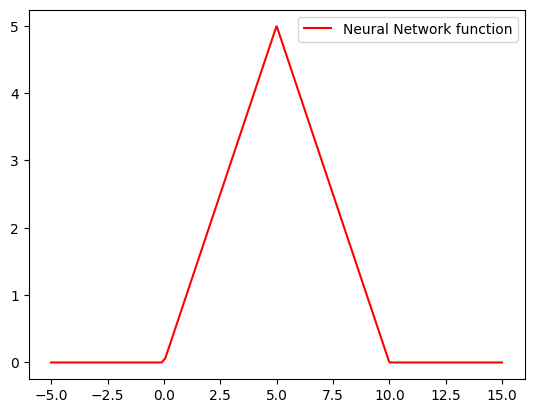

In [56]:
import torch
import utils.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import z3
import utils.duckdb as db

model = nn.ReLUFNN(input_size=1, hidden_size=2, num_hidden_layers=2, output_size=1)
model.load_state_dict(torch.load("models/basic_eval.pt", weights_only=True))
model.eval()

# So we can debug with queries...
db.load_pytorch_model_into_db(model)


x_train = np.linspace(-5, 15, 1000)
predicted = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()

plt.plot(x_train, predicted, 'r', label='Neural Network function')
plt.legend()
plt.show()

In [57]:
model(torch.tensor([0.5], dtype=torch.float32)).detach().numpy()

array([0.49924543], dtype=float32)

We want to verify 2 *correctness properties*, as defined by [Aws
2021](https://arxiv.org/abs/2109.10317).

**Example 1**: for the input range [-5, 15], f(x) should always be between 0 and 5

$$
\begin{gather}
\{ x \geq -5 \land x \leq 15 \} \\
r \leftarrow f(x) \\
\{ r \geq 0 \land r \leq 5 \}
\end{gather}
$$

**Example 2**: Between [0, 5], the function should always be increasing.

$$
\begin{gather}
\{ x \geq 0 \land x \leq 5 \land x' \geq 0 \land x' \leq 5 \land x > x' \} \\
r \leftarrow f(x) \\
r' \leftarrow f(x') \\
\{ r \geq r' \}
\end{gather}
$$

Also for reference, this is the network:

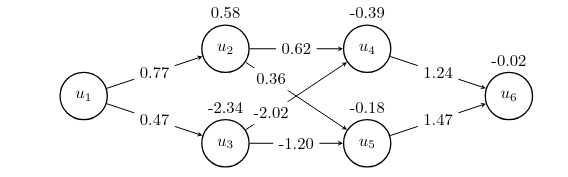

In [58]:
from IPython.display import Image
Image(filename='assets/network.png')

Let's jump into the first example.

In [59]:
x = z3.Real('x')
precondition = z3.And(x >= -5, x <= 15)
precondition

And(x >= -5, x <= 15)

In [60]:
r = z3.Real('r')
# We add a small value (0.1) to the bounds we expect, to account for some small
# fluctuations.
postcondition = z3.And(r >= -0.1, r <= 5.1)
postcondition

And(r >= -1/10, r <= 51/10)

Now the hard part: we have to encode the network. This is done according to the
Aws book. First, we encode the ReLU function:

In [61]:
def ReLU(x):
  return z3.If(x >= 0, x, z3.RealVal(0))

Let's get the weights and biases (by hand, because that's easiest for such a
small network)

In [62]:
state_dict = model.state_dict()

b2 = state_dict['linear_relu_stack.0.bias'][0].item()
b3 = state_dict['linear_relu_stack.0.bias'][1].item()
b4 = state_dict['linear_relu_stack.2.bias'][0].item()
b5 = state_dict['linear_relu_stack.2.bias'][1].item()
bout = state_dict['linear_relu_stack.4.bias'][0].item()

wi2 = state_dict['linear_relu_stack.0.weight'][0].item()
wi3 = state_dict['linear_relu_stack.0.weight'][1].item()
w24 = state_dict['linear_relu_stack.2.weight'][0][0].item()
w25 = state_dict['linear_relu_stack.2.weight'][1][0].item()
w34 = state_dict['linear_relu_stack.2.weight'][0][1].item()
w35 = state_dict['linear_relu_stack.2.weight'][1][1].item()
w4o = state_dict['linear_relu_stack.4.weight'][0][0].item()
w5o = state_dict['linear_relu_stack.4.weight'][0][1].item()


With these values, we can encode the nodes:

In [63]:
# The input node is easy, we already have it defined in the precondition.
v_in = x

# Node 2
v_in_2_0 = z3.Real('v_in_2_0')
v_o_2 = z3.Real('v_o_2')
F2 = (v_o_2 == ReLU(wi2 * v_in_2_0 + b2))

# Node 3
v_in_3_0 = z3.Real('v_in_3_0')
v_o_3 = z3.Real('v_o_3')
F3 = (v_o_3 == ReLU(wi3 * v_in_3_0 + b3))

# Node 4
# Gets a bit harder, requires a summation.
v_in_4_0, v_in_4_1 = z3.Reals('v_in_4_0 v_in_4_1')
v_o_4 = z3.Real('v_o_4')
F4 = (v_o_4 == ReLU(z3.Sum([w24 * v_in_4_0, w34 * v_in_4_1]) + b4))

# Node 5
v_in_5_0, v_in_5_1 = z3.Reals('v_in_5_0 v_in_5_1')
v_o_5 = z3.Real('v_o_5')
F5 = (v_o_5 == ReLU(z3.Sum([w25 * v_in_5_0, w35 * v_in_5_1]) + b5))

# Output
v_in_o_0, v_in_o_1 = z3.Reals('v_in_o_0 v_in_o_1')
v_out = z3.Real('v_out')
FO = (v_out == z3.Sum([w4o * v_in_o_0, w5o * v_in_o_1]) + bout)

FV = z3.And(F2, F3, F4, F5, FO)


And the edges:

In [64]:
FE = z3.And([
    v_in_2_0 == v_in,
    v_in_3_0 == v_in,
    v_in_4_0 == v_o_2,
    v_in_4_1 == v_o_3,
    v_in_5_0 == v_o_2,
    v_in_5_1 == v_o_3,
    v_in_o_0 == v_o_4,
    v_in_o_1 == v_o_5
])

The entire neural network is then encoded as:

In [65]:
FG = z3.And(FV, FE)

The entire formula is:

precondition AND network AND input AND output IMPLIES postcondition

Which is what we'll be encoding next.

In [66]:
a = z3.And([
    precondition,
    FG,
    v_in == x, # Link input
    r == v_out # Link output
])

correctness_property = z3.Implies(a, postcondition)

Now we can check if the correctness property holds (i.e. it is valid (i.e., it
is SAT for all possible interpretations)). We do this by checking if the
negation of the property is UNSAT.

In [67]:
solver = z3.Solver()
solver.add(z3.Not(correctness_property))

if solver.check() == z3.unsat:
    print("Correctness property holds")
else:
    print("Can't prove correctness property")

Correctness property holds


Now let's take the same example, but make the postcondition something that we
expect to fail:

In [68]:
postcondition = z3.And(r >= 1, r <= 5.1)

In [69]:
correctness_property = z3.Implies(a, postcondition)

solver = z3.Solver()
solver.add(z3.Not(correctness_property))

if solver.check() == z3.unsat:
    print("Correctness property holds")
else:
    print("Can't prove correctness property")

Can't prove correctness property


It fails, as expected. Now let's try to implement example 2. We obviously need
adapted pre- and postconditions:

In [70]:
x, x_prime = z3.Reals('x x_prime')
precondition = z3.And(x >= 0.1, x <= 4.9, x > x_prime)

r, r_prime = z3.Reals('r r_prime')
postcondition = z3.And(r >= r_prime)

But we also have to encode the additional evaluation on x'. For this we define a
function to create a graph encoding, so we can reuse it:

In [71]:
def create_graph_encoding(v_in, suffix=''):
    # Node 2
    v_in_2_0 = z3.Real(f"v_in_2_0{suffix}")
    v_o_2 = z3.Real(f"v_o_2{suffix}")
    F2 = (v_o_2 == ReLU(wi2 * v_in_2_0 + b2))

    # Node 3
    v_in_3_0 = z3.Real(f'v_in_3_0{suffix}')
    v_o_3 = z3.Real(f'v_o_3{suffix}')
    F3 = (v_o_3 == ReLU(wi3 * v_in_3_0 + b3))

    # Node 4
    # Gets a bit harder, requires a summation.
    v_in_4_0, v_in_4_1 = z3.Reals(f'v_in_4_0{suffix} v_in_4_1{suffix}')
    v_o_4 = z3.Real(f'v_o_4{suffix}')
    F4 = (v_o_4 == ReLU(z3.Sum([w24 * v_in_4_0, w34 * v_in_4_1]) + b4))

    # Node 5
    v_in_5_0, v_in_5_1 = z3.Reals(f'v_in_5_0{suffix} v_in_5_1{suffix}')
    v_o_5 = z3.Real(f'v_o_5{suffix}')
    F5 = (v_o_5 == ReLU(z3.Sum([w25 * v_in_5_0, w35 * v_in_5_1]) + b5))

    # Output
    v_in_o_0, v_in_o_1 = z3.Reals(f'v_in_o_0{suffix} v_in_o_1{suffix}')
    v_out = z3.Real(f'v_out{suffix}')
    FO = (v_out == z3.Sum([w4o * v_in_o_0, w5o * v_in_o_1]) + bout)

    FV = z3.And(F2, F3, F4, F5, FO)

    FE = z3.And([
        v_in_2_0 == v_in,
        v_in_3_0 == v_in,
        v_in_4_0 == v_o_2,
        v_in_4_1 == v_o_3,
        v_in_5_0 == v_o_2,
        v_in_5_1 == v_o_3,
        v_in_o_0 == v_o_4,
        v_in_o_1 == v_o_5
    ])

    return z3.And(FV, FE), v_out

In [72]:
FG, v_out = create_graph_encoding(x)
FG_prime, v_out_prime = create_graph_encoding(x_prime, suffix='_prime')

a = z3.And([
    precondition,
    FG,
    FG_prime,
    r == v_out,
    r_prime == v_out_prime
])

correctness_property = z3.Implies(a, postcondition)

solver = z3.Solver()
solver.add(z3.Not(correctness_property))

if solver.check() == z3.unsat:
    print("Correctness property holds")
else:
    print("Can't prove correctness property")

Correctness property holds


And we'll try an invalid input to see if that fails:

In [73]:
precondition = z3.And(x >= 0.1, x <= 6, x > x_prime)

a = z3.And([
    precondition,
    FG,
    FG_prime,
    r == v_out,
    r_prime == v_out_prime
])

correctness_property = z3.Implies(a, postcondition)

solver = z3.Solver()
solver.add(z3.Not(correctness_property))

if solver.check() == z3.unsat:
    print("Correctness property holds")
else:
    print("Can't prove correctness property")

Can't prove correctness property


### The Real Implementation (Sine)

We'll do the same for a sine function model, so we can compare it to the FO(SUM)
method.

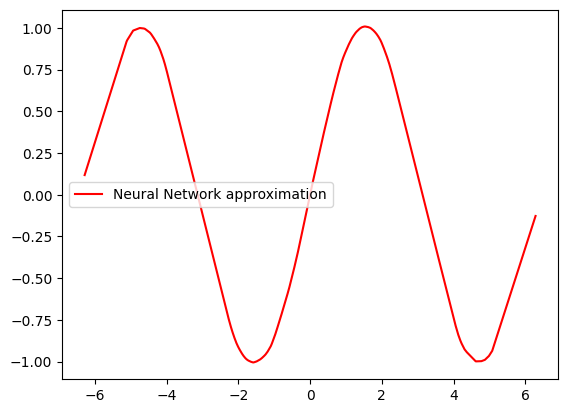

In [ ]:

sine_model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=1000, num_hidden_layers=1)
# If this file does not exist, run the preparation notebook of the demo app.
sine_model.load_state_dict(torch.load("../mnist-showcase-app/models/pwl_geometric_sine.pt", weights_only=True))
sine_model.eval()

x_train = np.linspace(-2 * math.pi, 2 * math.pi, 10000)
y_train = np.array([math.sin(x) for x in x_train])

with torch.no_grad():
    predicted = (
        sine_model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()
    )

fig, ax = plt.subplots()
ax.plot(x_train, predicted, "r", label="Neural Network approximation")
ax.legend()
plt.show(fig)

We can see that the model approximates a sine function -- at least, on the range
we trained on. Purely informational, here it is with the x-range a bit bigger.

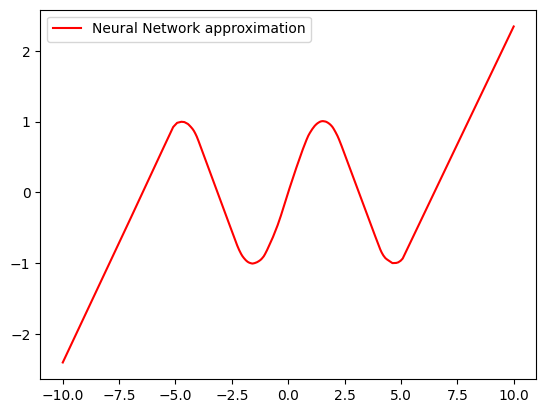

In [75]:
x_train = np.linspace(-10, 10, 10000)

with torch.no_grad():
    predicted = (
        sine_model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()
    )

fig, ax = plt.subplots()
ax.plot(x_train, predicted, "r", label="Neural Network approximation")
ax.legend()
plt.show(fig)

Now we want to formally verify the same properties on the sine function.

**Example 1**: for the input range [-6, 6], f(x) should always be between -1 and


$$
\begin{gather}
\{ x \geq -6 \land x \leq 6 \} \\
r \leftarrow f(x) \\
\{ r \geq -1 \land r \leq 1 \}
\end{gather}
$$

**Example 2**: Between [-1, 1], the function should always be increasing.

$$
\begin{gather}
\{ x \geq -1 \land x \leq 1 \land x' \geq -1 \land x' \leq 1 \land x > x' \} \\
r \leftarrow f(x) \\
r' \leftarrow f(x') \\
\{ r \geq r' \}
\end{gather}
$$

We'll start with example 1. Let's see if we can encode the precondition in Z3.

In [76]:
x = z3.Real('x')
precondition = z3.And(x >= -6, x <= 6)
precondition

And(x >= -6, x <= 6)

Great, and now the postcondition:

In [77]:
r = z3.Real('r')
postcondition = z3.And(r >= -1.5, r <= 1.5)
postcondition

And(r >= -3/2, r <= 3/2)

In [78]:
state_dict = sine_model.state_dict()
hidden_weights = state_dict['linear_relu_stack.0.weight']
hidden_biases = state_dict['linear_relu_stack.0.bias']
output_weights = state_dict['linear_relu_stack.2.weight']
output_bias = state_dict['linear_relu_stack.2.bias'].item()

In [79]:
v_in = z3.Real('v_in')

hidden_nodes = z3.RealVector("hidden_out_", len(hidden_biases))

# Nodes
hidden_nodes_output = []
out_weights = []
for i, v_i_out in enumerate(hidden_nodes):
    weight = hidden_weights[i].item()
    bias = hidden_biases[i].item()
    hidden_nodes_output.append(v_i_out == ReLU(weight * v_in + bias))

    out_weight = output_weights[0][i].item()
    out_weights.append(out_weight * v_i_out)

v_out = z3.Real('v_out')
FO = (v_out == z3.Sum(out_weights) + output_bias)

FG = z3.And(z3.And(hidden_nodes_output), FO)

In [80]:
a = z3.And([
    precondition,
    FG,
    v_in == x, # Link input
    r == v_out # Link output
])

correctness_property = z3.Implies(a, postcondition)

We run in the NP-completeness of SAT solving: this doesn't finish in reasonable
time (i.e. a few minutes) on my humble machine.

## Marabou

All of the above required a lot of manual work to encode the network. Marabou is
a tool that automates a lot of this away, we simply need to pass it a supported
model file (e.g. TensorFlow, ONNX).

### Simple network

We'll start again with the simple network. First off, we need to have an ONNX
presentation of it.

In [81]:
MODEL_PATH_SIMPLE = "models/marabou_simple.onnx"
dummy_input = torch.randn(1, 1)  # A dummy input for the export
onnx_path = MODEL_PATH_SIMPLE
torch.onnx.export(model, dummy_input, onnx_path, input_names=['input'], output_names=['output'])

Now we can use it with Marabou

In [82]:
from maraboupy import Marabou
import numpy as np

# Marabou prints a whole lot by default, disable it.
options = Marabou.createOptions(verbosity = 0)

2025-03-24 16:57:53.643476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 16:57:53.735596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 16:57:53.759078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Instructions for updating:
non-resource variables are not supported in the long term


Marabou works by checking if there exists an assignment to the input vars in the
given bounds that gives an output that satisfies the output constraints. So, we
need to check if an input in [-5, 15] yields something outside of [-0.1, 5]
(with 0.1 added for small errors).

In [91]:
network = Marabou.read_onnx(MODEL_PATH_SIMPLE)

input_var = network.inputVars[0][0][0]
output_var = network.outputVars[0][0][0]

# We'll check if all values in the input range [-5, 15]
# has an output bound between [-0.1, 5.1], cfr example 1
network.setLowerBound(input_var,-5.0)
network.setUpperBound(input_var, 15.0)


#network.setLowerBound(output_var, 7.1)
network.setUpperBound(output_var, -0.1)

sat, values, statistics  = network.solve(options=options)
if sat == 'sat':
    print("Found a counterexample for r >= 0")
else:
    print("No counterexample found")

#del network.upperBounds[output_var]
#network.setLowerBound(output_var, 5.1)

#sat, values, statistics  = network.solve(options=options)
#if sat == 'sat':
#    print("Found a counterexample for r <= 5")
#else:
#    print("No counterexample found")

unsat
No counterexample found


Great, this proves our correctness property with way less work. Let's check if
the inverse also works, as before, i.e. check if it correctly finds a
counterexample.

In [132]:
network = Marabou.read_onnx(MODEL_PATH_SIMPLE)

input_var = network.inputVars[0][0][0]
output_var = network.outputVars[0][0][0]

network.setLowerBound(input_var, -5.0)
network.setUpperBound(input_var, 15.0)

# Lower bound changed to 1. This should fail!
network.setUpperBound(output_var, 1)

sat, values, statistics  = network.solve(options=options)
if sat == 'sat':
    print("Found a counterexample")
else:
    print("No counterexample found")

sat
input 0 = -5.0
output 0 = -0.00022276738309301436
Found a counterexample


We found a counterexample: for input -5, the network outputs ~0, so <= 1. 

Now, example 2 requires that we take 2 inputs, $x_1$ and $x_2$, and evaluate the
network two times, $r_1 \leftarrow f(x_1)$ and $r_2 \leftarrow f(x_2)$.
Unfortunately, executing a network twice is still unsupported in Marabou as of
this moment.

Sources:
- Github issue that asks for this feature: https://github.com/NeuralNetworkVerification/Marabou/issues/598
- Vehicle marabou config: https://github.com/vehicle-lang/vehicle/blob/f8dcd995b07d5c6178d10829c0d533cea7def2f0/vehicle/src/Vehicle/Verify/Verifier/Marabou.hs#L28

Instead, we'll try an alternative. For this network, the function between $x=0$
and $x=5$ is simply $f(x)$. So, we can verify if the network evaluation is equal
to its input (+/- some epsilon) in this range. To use the same notation as
before:

$$
\begin{gather}
\{ x \geq 0.1 \land x \leq 4.9 \} \\
r \leftarrow f(x) \\
\{ |r-x| \leq \epsilon \}
\end{gather}
$$

In Marabou, we have to work with equations. What we want to check is this:

$$
|x - y| <= \epsilon
$$

We have to convert this to inequality constraints of the form:

$$
\Sigma_i vars_i * coeffs_i <= scalar
$$

For absolute value, we know we can write this as follows:

$$
-\epsilon <= x - y <= \epsilon
$$

So split into two inequalities of the correct form:

$$
+1x + -1y <= \epsilon
$$

$$
-1x + +1y <= \epsilon
$$

In our python implementation we will use $-\epsilon$ instead, because we are
looking for a counterexample.

Additionally, because these are two equations, we will run marabou twice: one
time for each equation.

In [133]:
range = [0.1, 4.9]
epsilon = 0.1

network = Marabou.read_onnx(MODEL_PATH_SIMPLE)
x = network.inputVars[0][0][0]
y = network.outputVars[0][0][0]
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# -x + y <= -epsilon
network.addInequality([x, y], [-1, 1], -epsilon)

sat1 , _, _  = network.solve(options=options)

network = Marabou.read_onnx(MODEL_PATH_SIMPLE)
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# x - y <= -epsilon
network.addInequality([x, y], [1, -1], -epsilon)

sat2 , _, _  = network.solve(options=options)

unsat
unsat


Both equations are unsat; we can't find a counterexample; the property holds.

In [134]:
range = [0.1, 6]
epsilon = 0.1

network = Marabou.read_onnx(MODEL_PATH_SIMPLE)
x = network.inputVars[0][0][0]
y = network.outputVars[0][0][0]
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# -x + y <= -epsilon
network.addInequality([x, y], [-1, 1], -epsilon)

sat1 , _, _  = network.solve(options=options)

network = Marabou.read_onnx(MODEL_PATH_SIMPLE)
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# x - y <= -epsilon
network.addInequality([x, y], [1, -1], -epsilon)

sat2 , _, _  = network.solve(options=options)

sat
input 0 = 5.049994027184484
output 0 = 4.949994027184431
unsat


If we increase the range we _do_ find a counterexample, as expected.

### Sine

Now let's see if we can do the same for the sine example and actually get to a
result this time.

In [135]:
MODEL_PATH_SINE = "models/marabou_sine.onnx"
dummy_input = torch.randn(1, 1)  # A dummy input for the export
onnx_path = MODEL_PATH_SINE
torch.onnx.export(sine_model, dummy_input, onnx_path, input_names=['input'], output_names=['output'])

In [136]:
network = Marabou.read_onnx(MODEL_PATH_SINE)

input_var = network.inputVars[0][0][0]
output_var = network.outputVars[0][0][0]

# We'll check if all values in the input range [-6,6]
# has an output bound between [-1.1, 1.1], cfr example 1
network.setLowerBound(input_var,-6.0)
network.setUpperBound(input_var, 6.0)

network.setUpperBound(output_var, -1.1)

sat, values, statistics  = network.solve(options=options)
if sat == 'sat':
    print("Found a counterexample for r >= -1.1")
else:
    print("No counterexample found")

del network.upperBounds[output_var]
network.setLowerBound(output_var, 1.1)

sat, values, statistics  = network.solve(options=options)
if sat == 'sat':
    print("Found a counterexample for r <= 1.1")
else:
    print("No counterexample found")

unsat
No counterexample found
unsat
No counterexample found


And now a check that should fail:

In [137]:
network = Marabou.read_onnx(MODEL_PATH_SINE)

input_var = network.inputVars[0][0][0]
output_var = network.outputVars[0][0][0]

# We'll check if all values in the input range [-6,6]
# has an output bound between [-1.1, 1.1], cfr example 1
network.setLowerBound(input_var,-6.0)
network.setUpperBound(input_var, 6.0)

network.setUpperBound(output_var, -0.9)

sat, values, statistics  = network.solve(options=options)
if sat == 'sat':
    print("Found a counterexample for r >= -0.9")
else:
    print("No counterexample found")

sat
input 0 = 4.241784982097351
output 0 = -0.9
Found a counterexample for r >= -0.9


Notice how much more optimized Marabou is! It solves this network in ~10
seconds, as apposed to Z3 which doesn't finish on the sine network in reasonable
time.

Now for example 2, we have the same issue as before: Marabou can't work with two
network evaluations. Instead, we'll test something similar as the other model:
that the sine function is +/- $f(x) = x$ between -1 and 1.

In [138]:
range = [-1, 1]
epsilon = 0.2

network = Marabou.read_onnx(MODEL_PATH_SINE)
x = network.inputVars[0][0][0]
y = network.outputVars[0][0][0]
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# -x + y <= -epsilon
network.addInequality([x, y], [-1, 1], -epsilon)

sat1 , _, _  = network.solve(options=options)

network = Marabou.read_onnx(MODEL_PATH_SINE)
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# x - y <= -epsilon
network.addInequality([x, y], [1, -1], -epsilon)

sat2 , _, _  = network.solve(options=options)

unsat
unsat


The property holds! Now to prove it doesn't hold if we extend the range:

In [139]:
range = [-1.2, 1.2]
epsilon = 0.2

network = Marabou.read_onnx(MODEL_PATH_SINE)
x = network.inputVars[0][0][0]
y = network.outputVars[0][0][0]
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# -x + y <= -epsilon
network.addInequality([x, y], [-1, 1], -epsilon)

sat1 , _, _  = network.solve(options=options)

network = Marabou.read_onnx(MODEL_PATH_SINE)
network.setLowerBound(x, range[0])
network.setUpperBound(x, range[1])
# x - y <= -epsilon
network.addInequality([x, y], [1, -1], -epsilon)

sat2 , _, _  = network.solve(options=options)

sat
input 0 = 1.1211126346155684
output 0 = 0.9192756190714626
sat
input 0 = -1.1153027680741503
output 0 = -0.9153027680741501


## Vehicle

[Vehicle](https://github.com/vehicle-lang/vehicle) is a verification tool
based on a specification language. We experimented with the `vehicle` CLI.

VCL is the specification language in question, which is very clear and succinct,
and easy to pick up for people familiar with functional programming and/or
theorem proving. This is our monotonicity property in VCL:

```txt
-- test.vcl
type Input = Tensor Rat [1]
type Output = Tensor Rat [1]

@network
f : Input -> Output

validInput : Input -> Bool
validInput x = 0 <= x ! 0 <= 5

@property
monotonicity : Bool
monotonicity = forall x1 x2 . validInput x1 and validInput x2
    => f x1 ! 0 <= f x2 ! 0
```

Which we run as follows:

```bash
$ vehicle verify -s test.vcl --network f:models/marabou_simple.onnx --verifier Marabou
```

Unfortunately, since we use Marabou as the backend, Vehicle won't verify this:

```
Warning: In property 'monotonicity', at least one of the generated queries were found to contain a strict inequality (i.e. constraints of the form 'x < y'). Unfortunately the Marabou query format only supports non-strict inequalities (i.e. constraints of the form 'x <= y').

In order to provide support, Vehicle has automatically converted the strict inequalities to non-strict inequalites. This is not sound, but errors will be at most the floating point epsilon used by the verifier, which is usually very small (e.g. 1e-9). However, this may lead to unexpected behaviour (e.g. loss of the law of excluded middle).

See https://github.com/vehicle-lang/vehicle/issues/74 for further details.

Verifying properties:
  monotonicity [...................................................] 0/1 queries
    result: ? - Marabou errored

Error: The Marabou verifier currently doesn't support properties that involve multiple applications of the same network. This property applies:
  the network 'f' 2 times
```

We can implement the alternative without problems though:

```
type Input = Tensor Rat [1]
type Output = Tensor Rat [1]

@network
f : Input -> Output

validInput : Input -> Bool
validInput x = 0.1 <= x ! 0 <= 4.9

@property
increasing : Bool
increasing = forall x1 . validInput x1
    => (x1 ! 0 <= f x1 ! 0 + 1) and (x1 ! 0 >= f x1 ! 0 - 1)
```

Example 1, the boundedness problem, is also trivial to implement in Vehicle.